## K Nearest Neighbors Model for a Regression Problem

In this notebook, we use the K Nearest Neighbors method to build a regressor to predict the __log_votes__ field of our review dataset.


1. Reading the dataset
2. Exploratory data analysis and missing value imputation
3. Stop word removal and stemming
4. Scaling numerical fields
5. Splitting the training dataset into training and validation
6. Computing Bag of Words features
7. Fitting the regression model
8. Checking model performance on the validation dataset
9. Trying different K values
10. Checking few other things to see if performance can be improved

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes). *This field is a processed version of the votes field. People can click on the "helpful" button when they find a customer review helpful. This increases the vote by 1. __log_votes__ is calculated like this log(1+votes). This formulation helps us get a smaller range for votes.*

### 1. Reading the dataset

We will use the __pandas__ library to read our dataset.

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/aws-samples/aws-machine-learning-embark-nlp/master/DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv'
#df = pd.read_csv(url,index_col=0,parse_dates=[0])
df = pd.read_csv(url,parse_dates=[0])

In [2]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


In [3]:
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55000, 6)


In [4]:
df.columns

Index(['reviewText', 'summary', 'verified', 'time', 'rating', 'log_votes'], dtype='object')

### 2. Exploratory data analysis and missing value imputation

In [5]:
df["log_votes"].min()

0.0

In [6]:
df["log_votes"].max()

7.799753318287247

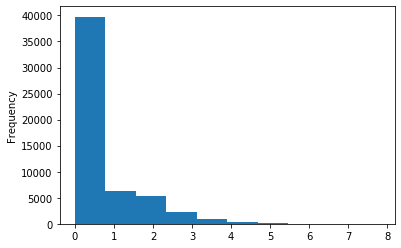

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [8]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


Let's fill-in the missing values for __reviewText__ below. We will just use the placeholder "Missing" here.

In [9]:
df["reviewText"].fillna("Missing", inplace=True)

In [10]:
df["summary"].fillna("Missing", inplace=True) #similarly, placeholders for summary column

### 3. Stop word removal and stemming

In [11]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list. It is because those words are actually useful to understand the sentiment in the sentence.

In [12]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here.
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [13]:
print("Pre-processing the reviewText field")
df["reviewText"] = process_text(df["reviewText"].tolist()) 

Pre-processing the reviewText field


### 4. Scaling numerical fields:

We will apply min-max scaling to our rating field so that they will be between 0-1.

In [14]:
df["rating"] = (df["rating"] - df["rating"].min())/(df["rating"].max()-df["rating"].min())
df["time"] = (df["time"] - df["time"].min())/(df["time"].max()-df["time"].min())

### 5. Splitting the training dataset into training and validation

Sklearn library has a useful function to split datasets. We will use the __train_test_split()__ function. In the example below, we get 90% of the data for training and 10% is left for validation.

In [15]:
from sklearn.model_selection import train_test_split

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "rating", "time"]],
                                                  df["log_votes"].tolist(),
                                                  test_size=0.10,
                                                  shuffle=True
                                                 )

### 6. Computing Bag of Words features

We are using binary features here. TF and TF-IDF are also other options.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(binary=True,
                                   max_features=50    # Limit the vocabulary size
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())

Let's print our vocabulary below. The number next to the word is its index in the vocabulary.

In [17]:
print(tfidf_vectorizer.vocabulary_)

{'work': 47, 'product': 27, 'use': 39, 'year': 49, 'version': 42, 'problem': 26, 'download': 6, 'instal': 15, 'time': 36, 'new': 22, 'upgrad': 38, 'good': 12, 'softwar': 33, 'price': 25, 'need': 21, 'recommend': 31, 'would': 48, 'buy': 3, 'window': 46, 'not': 23, 'get': 11, 'great': 13, 've': 41, 'look': 17, 'make': 18, 'want': 43, 'support': 35, 'help': 14, 'way': 44, 'still': 34, 'tri': 37, 'file': 9, 'back': 1, 'find': 10, 'better': 2, 'also': 0, 'easi': 7, 'much': 20, 'run': 32, 'well': 45, 'could': 5, 'comput': 4, 'mani': 19, 'realli': 30, 'like': 16, 'program': 28, 'even': 8, 'user': 40, 'one': 24, 'purchas': 29}


### 7. Fitting the regression model

We will use __KNeighborsRegressor__ from Sklearn library with __n_neighbors__ = 5. We will try different values in the last section.

In [18]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

from time import time
start = time()

# Let' merge our features
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values)
                                  )

# Using the default KNN with 5 nearest neighbors
knnRegressor = KNeighborsRegressor(n_neighbors=5)
knnRegressor.fit(X_train_features, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

### 8. Checking model performance on the validation dataset

We kept some of our data as validation data. Let's check model performance on this validation dataset. 

One evaluation metrics for regression problems is the Mean Squared Error ($\mathrm{MSE}$), defined as:
$$
\mathrm{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2,
$$
measuring the mean of all squared differences between the data values $y_i$ and the predicted values $\hat{y_i}$, where $n$ is the number of data records.

Another regression evaluation metric is $\mathrm{R^2}$, measuring the fraction of the variance in the dataset our model can explain:
$$
\mathrm{R^2} = 1- \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2},
$$
where $\bar y = \frac{1}{n}\sum_{i = 1}^n y_i$ is the mean value of the data values $y_i$. 

In [19]:
from sklearn.metrics import r2_score, mean_squared_error

X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values, 
                                  X_val["time"].values))

val_predictions = knnRegressor.predict(X_val_features)

end = time()
print('KNN Training and validation time for one value of K (in seconds):', end-start)

print("Mean_squared_error: %f,  R_square_score: %f" % (mean_squared_error(y_val, val_predictions), r2_score(y_val, val_predictions)))

KNN Training and validation time for one value of K (in seconds): 45.17020630836487
Mean_squared_error: 0.805364,  R_square_score: 0.117523


### 9. Trying different K values

Let's try different K values and see how the model performs with each one.

In [20]:
K_values = [5, 10, 20, 25, 30, 40, 50]

for K in K_values:
    knnRegressor = KNeighborsRegressor(n_neighbors=K)
    knnRegressor.fit(X_train_features, y_train)
    val_predictions = knnRegressor.predict(X_val_features)
    print("K=%d, Mean_squared_error: %f,  R_square_score: %f" % (K, mean_squared_error(y_val, val_predictions), r2_score(y_val, val_predictions)))

K=5, Mean_squared_error: 0.805364,  R_square_score: 0.117523
K=10, Mean_squared_error: 0.770161,  R_square_score: 0.156096
K=20, Mean_squared_error: 0.759969,  R_square_score: 0.167264
K=25, Mean_squared_error: 0.757802,  R_square_score: 0.169639
K=30, Mean_squared_error: 0.757024,  R_square_score: 0.170491
K=40, Mean_squared_error: 0.755396,  R_square_score: 0.172275
K=50, Mean_squared_error: 0.756126,  R_square_score: 0.171475


### Word Counts

Word counts can be simply calculated using the same __CountVectorizer()__ function __without__ the __binary__ parameter.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(max_features=50)    # Limit the vocabulary size
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())

### Fitting the regression model with Word Counts

In [22]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

from time import time
start = time()

# Let' merge our features
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values)
                                  )

# Using the default KNN with 5 nearest neighbors
knnRegressor = KNeighborsRegressor(n_neighbors=5)
knnRegressor.fit(X_train_features, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

### Checking model performance with Word Count

In [23]:
from sklearn.metrics import r2_score, mean_squared_error

X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values, 
                                  X_val["time"].values))

val_predictions = knnRegressor.predict(X_val_features)

end = time()
print('KNN Training and validation time for one value of K (in seconds):', end-start)

print("Mean_squared_error: %f,  R_square_score: %f" % (mean_squared_error(y_val, val_predictions), r2_score(y_val, val_predictions)))

KNN Training and validation time for one value of K (in seconds): 42.620521783828735
Mean_squared_error: 0.822351,  R_square_score: 0.098909


The MSE value has been increased and time has been cut down to approximately half. 

### Fitting the regression model with TF vectorizer

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(use_idf=False,max_features=50)

# Fit and transform
X_train_text_vectors = tf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tf_vectorizer.transform(X_val["reviewText"].tolist())

In [25]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

from time import time
start = time()

# Let' merge our features
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values)
                                  )

# Using the default KNN with 5 nearest neighbors
knnRegressor = KNeighborsRegressor(n_neighbors=5)
knnRegressor.fit(X_train_features, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

### Checking model performance with TF vectorizer

In [26]:
from sklearn.metrics import r2_score, mean_squared_error

X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values, 
                                  X_val["time"].values))

val_predictions = knnRegressor.predict(X_val_features)

end = time()
print('KNN Training and validation time for one value of K (in seconds):', end-start)

print("Mean_squared_error: %f,  R_square_score: %f" % (mean_squared_error(y_val, val_predictions), r2_score(y_val, val_predictions)))

KNN Training and validation time for one value of K (in seconds): 44.515535831451416
Mean_squared_error: 0.747066,  R_square_score: 0.181403


### Fitting the regression model with TF IDF vectorizer

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True,max_features=50)

# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())

In [28]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

from time import time
start = time()

# Let' merge our features
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values)
                                  )

# Using the default KNN with 5 nearest neighbors
knnRegressor = KNeighborsRegressor(n_neighbors=5)
knnRegressor.fit(X_train_features, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

### Checking model performance with TF IDF vectorizer

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values, 
                                  X_val["time"].values))

val_predictions = knnRegressor.predict(X_val_features)

end = time()
print('KNN Training and validation time for one value of K (in seconds):', end-start)

print("Mean_squared_error: %f,  R_square_score: %f" % (mean_squared_error(y_val, val_predictions), r2_score(y_val, val_predictions)))

KNN Training and validation time for one value of K (in seconds): 48.21263289451599
Mean_squared_error: 0.744468,  R_square_score: 0.184250


# Fitting Linear Regression models and checking the validation performance

Let's first fit LinearRegression from Sklearn library, and check the performance on the validation dataset. Using the coef_ atribute, we can also print the learned weights of the model.

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
lrRegressor = LinearRegression()
lrRegressor.fit(X_train_features,y_train)
lrRegressor_val_predictions = lrRegressor.predict(X_val_features)
print("LinearRegression on validation: Mean_squared_error: %f, R_squared_score: %f" %\
      (mean_squared_error(y_val, lrRegressor_val_predictions), r2_score(y_val, lrRegressor_val_predictions)))
print("LinearRegression model weights: \n", lrRegressor.coef_)

LinearRegression on validation: Mean_squared_error: 0.633632, R_squared_score: 0.305698
LinearRegression model weights: 
 [ 0.37882511  0.18569065  0.17342977  0.02810875  0.0639604   0.14227191
  0.06879892  0.26993592  0.41287513  0.33034913  0.18254976  0.12033163
  0.13407989  0.19383979  0.17489861  0.17098964  0.34341139  0.40548892
  0.17452126  0.1435772   0.28559151  0.1584397   0.25739598  0.05910168
  0.147466    0.33784033  0.20604816  0.13204411  0.18432771  0.17911992
  0.32560781  0.42584004  0.21823761 -0.09139284  0.29086186  0.14029278
  0.24292381  0.14699231  0.28389383  0.06479309  0.31988433  0.33665088
  0.27666987  0.37050821  0.35051092  0.14869107  0.31643034  0.08851016
  0.08274091  0.16984067 -0.36073012 -1.77327376]


# Ridge (Linear Regression with L2 regularization)

Let's now fit Ridge from Sklearn library, and check the performance on the validation dataset.

To improve the performance of a LinearRegression model, Ridge is tuning model complexity by adding a L2

penalty score for complexity to the model cost function:

Cregularized(w)=C(w)+alpha∗||w||2

where w
is the model weights vector, and ||w||2=∑w2i

.The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of alpha
, weaker regularization; larger value of alpha, stronger regularization.

In [31]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
ridgeRegressor = Ridge(alpha = 100)
ridgeRegressor.fit(X_train_features, y_train)
ridgeRegressor_val_predictions = ridgeRegressor.predict(X_val_features)

print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
    (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))
      
print("Ridge model weights: \n", ridgeRegressor.coef_)

Ridge on Validation: Mean_squared_error: 0.633083,  R_square_score: 0.306300
Ridge model weights: 
 [ 0.33710393  0.16658409  0.15460978  0.02826003  0.06426838  0.11672356
  0.05168662  0.24772996  0.36537312  0.29546611  0.18055831  0.09548388
  0.10648171  0.17595235  0.16534583  0.16655178  0.31450348  0.35251353
  0.15983564  0.13342621  0.26831181  0.15269216  0.25003895  0.06598874
  0.13691095  0.32688851  0.18119864  0.12074688  0.16949043  0.16964397
  0.31431003  0.3724076   0.20031923 -0.0952992   0.25637325  0.14110337
  0.22604656  0.13542405  0.25594905  0.06901324  0.28542752  0.30045278
  0.26867991  0.33089162  0.30612365  0.13716068  0.29009699  0.06944907
  0.08760068  0.15398252 -0.3657378  -1.71269673]


In [42]:
alpha_values = [50, 100, 150, 200, 250]

for A in alpha_values:
    ridgeRegressor = Ridge(alpha = A)
    ridgeRegressor.fit(X_train_features, y_train)
    ridgeRegressor_val_predictions = ridgeRegressor.predict(X_val_features)
    print("K=%d, Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
    (A, mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

K=50, Ridge on Validation: Mean_squared_error: 0.633155,  R_square_score: 0.306221
K=100, Ridge on Validation: Mean_squared_error: 0.633083,  R_square_score: 0.306300
K=150, Ridge on Validation: Mean_squared_error: 0.633323,  R_square_score: 0.306037
K=200, Ridge on Validation: Mean_squared_error: 0.633808,  R_square_score: 0.305505
K=250, Ridge on Validation: Mean_squared_error: 0.634492,  R_square_score: 0.304756


# LASSO (Linear Regression with L1 regularization)

Let's also fit Lasso from Sklearn library, and check the performance on the validation dataset.

Lasso is tuning model complexity by adding a L1

penalty score for complexity to the model cost function:

Cregularized(w)=C(w)+alpha∗||w||1

where w
is the model weights vector, and ||w||1=∑|wi|

Again, the strength of the regularization is controlled by the regularizer parameter, alpha

Due to the geometry of L1 norm, with Lasso, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [34]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

LassoRegressor = Lasso(alpha=0.001)
LassoRegressor.fit(X_train_features, y_train)
LassoRegressor_val_predictions = LassoRegressor.predict(X_val_features)
print("Lasso on validation: Mean_Squared_Error: %f, R_Squared_Score: %f" % \
    (mean_squared_error(y_val, LassoRegressor_val_predictions), r2_score(y_val, LassoRegressor_val_predictions)))
      
print("Lasso model weights: \n", LassoRegressor.coef_)

Lasso on validation: Mean_Squared_Error: 0.633926, R_Squared_Score: 0.305375
Lasso model weights: 
 [ 0.31381443  0.0938786   0.0809034   0.          0.          0.06812602
  0.          0.19630092  0.34483799  0.25658037  0.14749587  0.02668533
  0.04296748  0.11003029  0.12961076  0.12270943  0.28102288  0.32527102
  0.09078496  0.08031686  0.23764603  0.11713189  0.21727912  0.
  0.08955     0.29907129  0.11975441  0.05752566  0.10291502  0.10257788
  0.28840594  0.35393882  0.12363913 -0.08514955  0.20377918  0.09995988
  0.18997859  0.07227622  0.20873718  0.03111594  0.23784724  0.27704558
  0.24775554  0.30290928  0.26299041  0.07725164  0.27013192  0.02275971
  0.03600531  0.1085075  -0.37706349 -1.85914313]


In [50]:
alpha_values_Lasso = [0.001, 0.005, 0.010, 0.050, 0.01]

for A in alpha_values_Lasso:
    LassoRegressor = Lasso(alpha = A)
    LassoRegressor.fit(X_train_features, y_train)
    LassoRegressor_val_predictions = LassoRegressor.predict(X_val_features)
    print("alpha_values=%f, Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
    (A, mean_squared_error(y_val, LassoRegressor_val_predictions),r2_score(y_val, LassoRegressor_val_predictions)))

alpha_values=0.001000, Ridge on Validation: Mean_squared_error: 0.633926,  R_square_score: 0.305375
alpha_values=0.005000, Ridge on Validation: Mean_squared_error: 0.657326,  R_square_score: 0.279735
alpha_values=0.010000, Ridge on Validation: Mean_squared_error: 0.669026,  R_square_score: 0.266915
alpha_values=0.050000, Ridge on Validation: Mean_squared_error: 0.744561,  R_square_score: 0.184147
alpha_values=0.010000, Ridge on Validation: Mean_squared_error: 0.669026,  R_square_score: 0.266915


The Mean Squared Error significantly improved with alpha value of 0.05

# ElasticNet (Linear Regression with L2 and L1 regularization)

Let's finally try ElasticNet from Sklearn library, and check the performance on the validation dataset.

ElasticNet is tuning model complexity by adding both L2 and L1 penalty scores for complexity to the model's cost function:

Cregularized(w)=C(w)+0.5∗alpha∗(1−l1ratio)||w||22+alpha∗l1ratio∗||w||1

and using two parameters, alpha and l1 ratio, to control the strength of the regularization.

In [36]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
enRegressor = ElasticNet(alpha = 0.001, l1_ratio=0.1)
enRegressor.fit(X_train_features,y_train)
enRegressor_val_predictions = enRegressor.predict(X_val_features)
print("Elastic Net on validation: Mean_Squared Error: %f, R_Squared_Error: %f" % \
     (mean_squared_error(y_val, enRegressor_val_predictions),r2_score(y_val,enRegressor_val_predictions)))
print("ElasticNet model weights: \n", enRegressor.coef_)

Elastic Net on validation: Mean_Squared Error: 0.633041, R_Squared_Error: 0.306345
ElasticNet model weights: 
 [ 0.35249824  0.16806482  0.15566804  0.02289057  0.05673637  0.12303015
  0.05210809  0.25253976  0.3834154   0.30677032  0.17844723  0.0994309
  0.11223518  0.177499    0.16649298  0.16442222  0.32395121  0.37212187
  0.15964692  0.13277887  0.2731316   0.15174482  0.25037761  0.05672899
  0.13690768  0.32919836  0.18596994  0.11959284  0.16967463  0.16780457
  0.31690599  0.39304282  0.20102115 -0.09283223  0.26593785  0.13699201
  0.23003903  0.1345208   0.26338172  0.06390058  0.29562912  0.31349956
  0.27021032  0.34516084  0.32083155  0.13651615  0.29952775  0.07307907
  0.08077847  0.15645405 -0.364623   -1.75429137]


# Weights shrinkage and sparsity

Let's compare weights ranges for all these regression models:

In [39]:
print('LinearRegression weights range: \n', np.abs(lrRegressor.coef_).min(), np.abs(lrRegressor.coef_).max())
print('Ridge weights range: \n', np.abs(ridgeRegressor.coef_).min(), np.abs(ridgeRegressor.coef_).max())
print('Lasso weights range: \n', np.abs(LassoRegressor.coef_).min(), np.abs(LassoRegressor.coef_).max())
print('ElasticNet weights range: \n', np.abs(enRegressor.coef_).min(), np.abs(enRegressor.coef_).max())

LinearRegression weights range: 
 0.02810874782481021 1.7732737578052393
Ridge weights range: 
 0.028260030990915935 1.7126967332283252
Lasso weights range: 
 0.0 1.8591431326238987
ElasticNet weights range: 
 0.02289057103996131 1.7542913706926486


The weights of all regularized models are lowered compared to LinearRegression, with some of the weights of Lasso and ElasticNet shrinked all the way to 0. Using sparsity, the Lasso regularization reduces the number of features, performing feature selection.
